![Two data scientists working on a dashboard.](hr-image-small.png)

A common problem when creating models to generate business value from data is that the datasets can be so large that it can take days for the model to generate predictions. Ensuring that your dataset is stored as efficiently as possible is crucial for allowing these models to run on a more reasonable timescale without having to reduce the size of the dataset.

We have been hired by a major online data science training provider called *Training Data Ltd.* to clean up one of their largest customer datasets. This dataset will eventually be used to predict whether their students are looking for a new job or not, information that they will then use to direct them to prospective recruiters.

We have been given access to `customer_train.csv`, which is a subset of their entire customer dataset, so we can create a proof-of-concept of a much more efficient storage solution. The dataset contains anonymized student information, and whether they were looking for a new job or not during training:

| Column       | Description                                  |
|------------- |--------------------------------------------- |
| `student_id`   | A unique ID for each student.                 |
| `city`  | A code for the city the student lives in.  |
| `city_development_index` | A scaled development index for the city.       |
| `gender` | The student's gender.       |
| `relevant_experience` | An indicator of the student's work relevant experience.       |
| `enrolled_university` | The type of university course enrolled in (if any).       |
| `education_level` | The student's education level.       |
| `major_discipline` | The educational discipline of the student.       |
| `experience` | The student's total work experience (in years).       |
| `company_size` | The number of employees at the student's current employer.       |
| `last_new_job` | The number of years between the student's current and previous jobs.       |
| `training_hours` | The number of hours of training completed.       |
| `job_change` | An indicator of whether the student is looking for a new job (`1`) or not (`0`).       |

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
ds_jobs = pd.read_csv("customer_train.csv")

# Copy the DataFrame for cleaning
ds_jobs_clean = ds_jobs.copy()
ds_jobs_clean.head()

,student_id,city,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,job_change
0,8949,city_103,0.920,Male,Has relevant experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1
1,29725,city_40,0.776,Male,No relevant experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0
2,11561,city_21,0.624,NaN,No relevant experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0
3,33241,city_115,0.789,NaN,No relevant experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1
4,666,city_162,0.767,Male,Has relevant experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0


In [22]:
# Create a dictionary of columns containing ordered categorical data
ordered_cats = {
    'relevant_experience': ['No relevant experience', 'Has relevant experience'],
    'enrolled_university': ['no_enrollment', 'Part time course', 'Full time course'],
    'education_level': ['Primary School', 'High School', 'Graduate', 'Masters', 'Phd'],
    'experience': ['<1'] + list(map(str, range(1, 21))) + ['>20'],
    'company_size': ['<10', '10-49', '50-99', '100-499', '500-999', '1000-4999', '5000-9999', '10000+'],
    'last_new_job': ['never', '1', '2', '3', '4', '>4']
}

In [23]:
# Loop through DataFrame columns to efficiently change data types
for col in ds_jobs_clean:
    # Convert integer columns to int32
    if ds_jobs_clean[col].dtype == 'int':
        ds_jobs_clean[col] = ds_jobs_clean[col].astype('int32')
    
    # Convert float columns to float16
    elif ds_jobs_clean[col].dtype == 'float':
        ds_jobs_clean[col] = ds_jobs_clean[col].astype('float16')
    
    # Convert columns containing ordered categorical data to ordered categories using dict
    elif col in ordered_cats.keys():
        category = pd.CategoricalDtype(ordered_cats[col], ordered=True)
        ds_jobs_clean[col] = ds_jobs_clean[col].astype(category)
    
    # Convert remaining columns to standard categories
    else:
        ds_jobs_clean[col] = ds_jobs_clean[col].astype('category')
ds_jobs_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   student_id              19158 non-null  category
 1   city                    19158 non-null  category
 2   city_development_index  19158 non-null  float16 
 3   gender                  14650 non-null  category
 4   relevant_experience     19158 non-null  category
 5   enrolled_university     18772 non-null  category
 6   education_level         18698 non-null  category
 7   major_discipline        16345 non-null  category
 8   experience              19093 non-null  category
 9   company_size            13220 non-null  category
 10  company_type            13018 non-null  category
 11  last_new_job            18735 non-null  category
 12  training_hours          19158 non-null  category
 13  job_change              19158 non-null  category
dtypes: category(13), float

In [24]:
# Filter students with 10 or more years experience at companies with at least 1000 employees
filtered_data = ds_jobs_clean[(ds_jobs_clean['experience'] >= '10') & (ds_jobs_clean['company_size'] >= '1000-4999')]
filtered_data .head()

,student_id,city,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,job_change
9,699,city_103,0.919922,NaN,Has relevant experience,no_enrollment,Graduate,STEM,17,10000+,Pvt Ltd,>4,123,0
12,25619,city_61,0.913086,Male,Has relevant experience,no_enrollment,Graduate,STEM,>20,1000-4999,Pvt Ltd,3,23,0
31,22293,city_103,0.919922,Male,Has relevant experience,Part time course,Graduate,STEM,19,5000-9999,Pvt Ltd,>4,141,0
34,26494,city_16,0.910156,Male,Has relevant experience,no_enrollment,Graduate,Business Degree,12,5000-9999,Pvt Ltd,3,145,0
40,2547,city_114,0.925781,Female,Has relevant experience,Full time course,Masters,STEM,16,1000-4999,Public Sector,2,14,0


In [26]:
# Display summary statistics for numerical columns
numerical_summary = filtered_data.describe()
print(numerical_summary)

       city_development_index
count             2201.000000
mean                 0.875488
std                  0.090027
min                  0.479004
25%                  0.893066
50%                  0.919922
75%                  0.919922
max                  0.949219


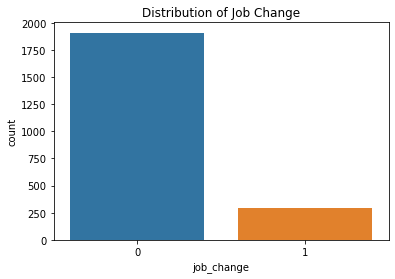

In [27]:
# Display the distribution of the target variable 'job_change'
sns.countplot(x='job_change', data=filtered_data)
plt.title('Distribution of Job Change')
plt.show()

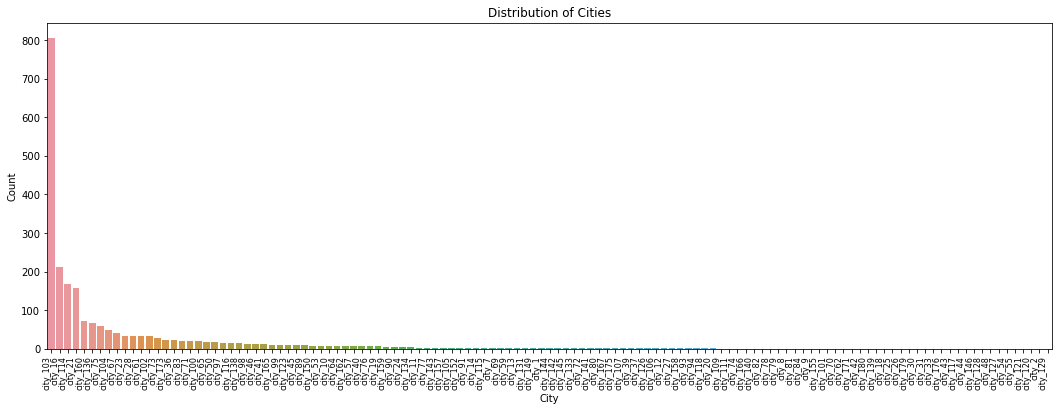

In [40]:
# Display the distribution of 'city' values with improved readability and larger figure size
plt.figure(figsize=(18, 6))  # Set the figure size

sns.countplot(x='city', data=filtered_data, order=filtered_data['city'].value_counts().index)
plt.title('Distribution of Cities')
plt.xticks(rotation=90, ha='right', fontsize=8)  # Rotate labels for better readability
plt.xlabel('City')  # Add xlabel for clarity
plt.ylabel('Count')  # Add ylabel for clarity
plt.show()

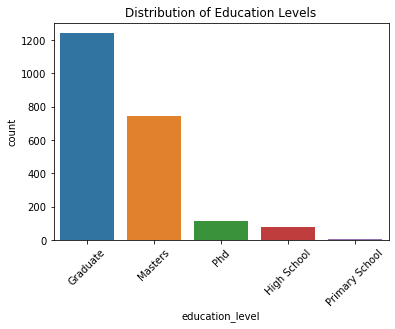

In [34]:
# Display the distribution of 'education_level'
sns.countplot(x='education_level', data=filtered_data, order=filtered_data['education_level'].value_counts().index)
plt.title('Distribution of Education Levels')
plt.xticks(rotation=45)
plt.show()